<a href="https://colab.research.google.com/github/SBShimm/Datathon/blob/main/Visual_Flix_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [741]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

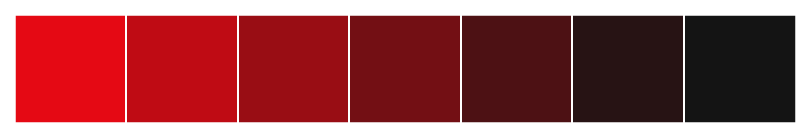

In [742]:
# 색상 선언해줄 때
grad = ["#e50914", "#bf0b14", "#990d14","#730f14","#4d1114" , "#271314","#141414"]
# 팔레트 색상 지정
sns.palplot(sns.color_palette(grad)) # 팔레트 색상 한번 출력해봄
sns.set_palette(sns.color_palette(grad)) # grad 팔레트로 선언!


In [743]:
! git clone https://github.com/SBShimm/Datathon.git

fatal: destination path 'Datathon' already exists and is not an empty directory.


# 1. 데이터 가져오기
#### 1) 데이터 종류

In [744]:
file_dir = '/content/Datathon/Dataset/Netflix_IMDB.csv'

data = pd.read_csv(file_dir)

In [745]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN


# 2. Data 전처리

#### 1)Data 추출

In [746]:
data['date_added'] = pd.to_datetime(data['date_added'])

In [747]:
# datetime 타입에서 년, 월, 일 추출
data['year'] = data.date_added.apply(lambda x : x.year)
data['month'] = data.date_added.apply(lambda x : x.month)
data['day'] = data.date_added.apply(lambda x : x.day)

#년월일 int로 변경
data['year'] = pd.to_datetime(data['year']).astype(np.int64)
data['month'] = pd.to_datetime(data['month']).astype(np.int64)
data['day'] = pd.to_datetime(data['day']).astype(np.int64)
data.drop(data.loc[data['year']<0].index, inplace=True)

data.head(3)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24


In [748]:
for i in data.columns:
    null_rate = data[i].isna().sum() / len(data) * 100 
    if null_rate > 0 :
        print("{}'s null rate :{}%".format(i,round(null_rate,2)))

director's null rate :29.87%
cast's null rate :9.34%
country's null rate :9.51%
rating's null rate :0.05%
duration's null rate :0.03%
IMDB's null rate :39.98%


In [749]:
#number of unique elements
data.nunique()

Unnamed: 0      8867
show_id         8797
type               2
title           8797
director        4528
cast            7682
country          748
date_added      1714
release_year      74
rating            17
duration         220
listed_in        513
description     8765
IMDB              79
year              14
month             12
day               31
dtype: int64

In [750]:
#Detect missing values
data.isna().sum()

Unnamed: 0         0
show_id            0
type               0
title              0
director        2649
cast             828
country          843
date_added         0
release_year       0
rating             4
duration           3
listed_in          0
description        0
IMDB            3545
year               0
month              0
day                0
dtype: int64

#### 2) Type 나누기, 장르세분화

In [751]:
def genere(what):
    if what == 'all':
        genere = data.listed_in.value_counts()
    else:
        genere = data[data['type'] == what].listed_in.value_counts()
    gener = {}
    
    for idx, val in genere.items():
        l = idx.split(',')
        for i in l:
            i = i.strip()
            if i in gener.keys():
                d = {}
                d[i] = val + gener[i]
                gener.update(d)
            else:
                d = {i:val}
                gener.update(d)
    theme, count = [],[]
    
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
    
    list_temp = (pd.DataFrame({'genere':theme, 'count': count})
        .sort_values('count', ascending = True))
    list_temp.reset_index(drop = True, inplace = True)
    
    return list_temp

In [752]:
tv_genere = genere('TV Show')
tv_genere

,genere,count
0,TV Shows,16
1,Classic & Cult TV,26
2,Stand-Up Comedy & Talk Shows,56
3,TV Thrillers,59
4,Teen TV Shows,69
5,TV Horror,76
6,TV Sci-Fi & Fantasy,84
7,Science & Nature TV,92
8,TV Mysteries,101
9,Korean TV Shows,155


In [753]:
mov_genere = genere('Movie')
mov_genere

,genere,count
0,Movies,58
1,Faith & Spirituality,66
2,Cult Movies,71
3,Anime Features,71
4,LGBTQ Movies,103
5,Classic Movies,116
6,Sports Movies,220
7,Sci-Fi & Fantasy,245
8,Stand-Up Comedy,343
9,Horror Movies,358


#### 3)Country data 전처리

In [754]:
data['first_country'] = data.country.str.extract(r'([a-zA-Z\s]+)')

In [755]:
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25,United States
1,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",6.3,2021,9,24,South Africa
2,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,NaN,2021,9,24,NaN
3,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",NaN,2021,9,24,NaN
4,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,NaN,2021,9,24,India


#### 4) 별점 data (내림차순)

In [756]:
df_rating = data.sort_values(by = 'IMDB',ascending=False)
df_rating.head(20)

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
6010,6010,s5941,TV Show,Breaking Bad,NaN,"Bryan Cranston, Aaron Paul, Anna Gunn, Dean No...",United States,2013-08-02,2013,TV-MA,5 Seasons,"Crime TV Shows, TV Dramas, TV Thrillers",A high school chemistry teacher dying of cance...,9.4,2013,8,2,United States
2558,2558,s2520,TV Show,Avatar: The Last Airbender,NaN,"Zach Tyler, Mae Whitman, Jack De Sena, Dee Bra...",United States,2020-05-15,2007,TV-Y7,3 Seasons,"Classic & Cult TV, Kids' TV, TV Action & Adven...",Siblings Katara and Sokka wake young Aang from...,9.3,2020,5,15,United States
3119,3119,s3072,TV Show,Reply 1988,NaN,"Lee Hye-ri, Park Bo-gum, Ryu Jun-yeol, Ko Kyou...",South Korea,2020-01-01,2015,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Take a nostalgic trip back to the late 1980s t...,9.2,2020,1,1,South Korea
688,688,s681,TV Show,The Last Dance,NaN,"Michael Jordan, Scottie Pippen, Dennis Rodman",United States,2021-06-19,2020,TV-MA,1 Season,Docuseries,This docuseries gives a definitive account of ...,9.2,2021,6,19,United States
3995,3995,s3939,TV Show,Our Planet,NaN,David Attenborough,"United States, United Kingdom",2019-04-05,2019,TV-PG,1 Season,"Docuseries, Science & Nature TV",Experience our planet's natural beauty and exa...,9.2,2019,4,5,United States
1915,1915,s1887,Movie,David Attenborough: A Life on Our Planet,"Alastair Fothergill, Jonnie Hughes, Keith Scholey",David Attenborough,"United States, United Kingdom",2020-10-04,2020,PG,84 min,Documentaries,"A broadcaster recounts his life, and the evolu...",9.1,2020,10,4,United States
3431,3431,s3382,TV Show,The Untamed,NaN,"Sean Xiao, Wang Yibo, Zoey Meng, Xuan Lu, Yu B...",China,2019-10-25,2019,TV-14,1 Season,"International TV Shows, TV Action & Adventure,...","In a magical world of inter-clan rivalry, two ...",9.1,2019,10,25,China
7365,7365,s7296,TV Show,Leyla and Mecnun,Onur Ünlü,"Ali Atay, Melis Birkan, Serkan Keskin, Ahmet M...",Turkey,2017-04-15,2014,TV-MA,3 Seasons,"International TV Shows, Romantic TV Shows, TV ...",Destiny brings Mecnun and Leyla together as ne...,9.1,2017,4,15,Turkey
1781,1781,s1756,TV Show,Leah Remini: Scientology and the Aftermath,NaN,"Leah Remini, Mike Rinder",United States,2020-11-01,2018,TV-14,3 Seasons,Docuseries,Former Scientology members share detailed acco...,9.0,2020,11,1,United States
5163,5163,s5097,TV Show,Fullmetal Alchemist: Brotherhood,Yasuhiro Irie,"Romi Park, Rie Kugimiya, Megumi Takamoto, Shin...",Japan,2018-01-01,2010,TV-14,5 Seasons,"Anime Series, International TV Shows",After both suffer physical damage – brothers E...,9.0,2018,1,1,Japan


# 1) Introduce Columns
### (1) Movie & TV Show

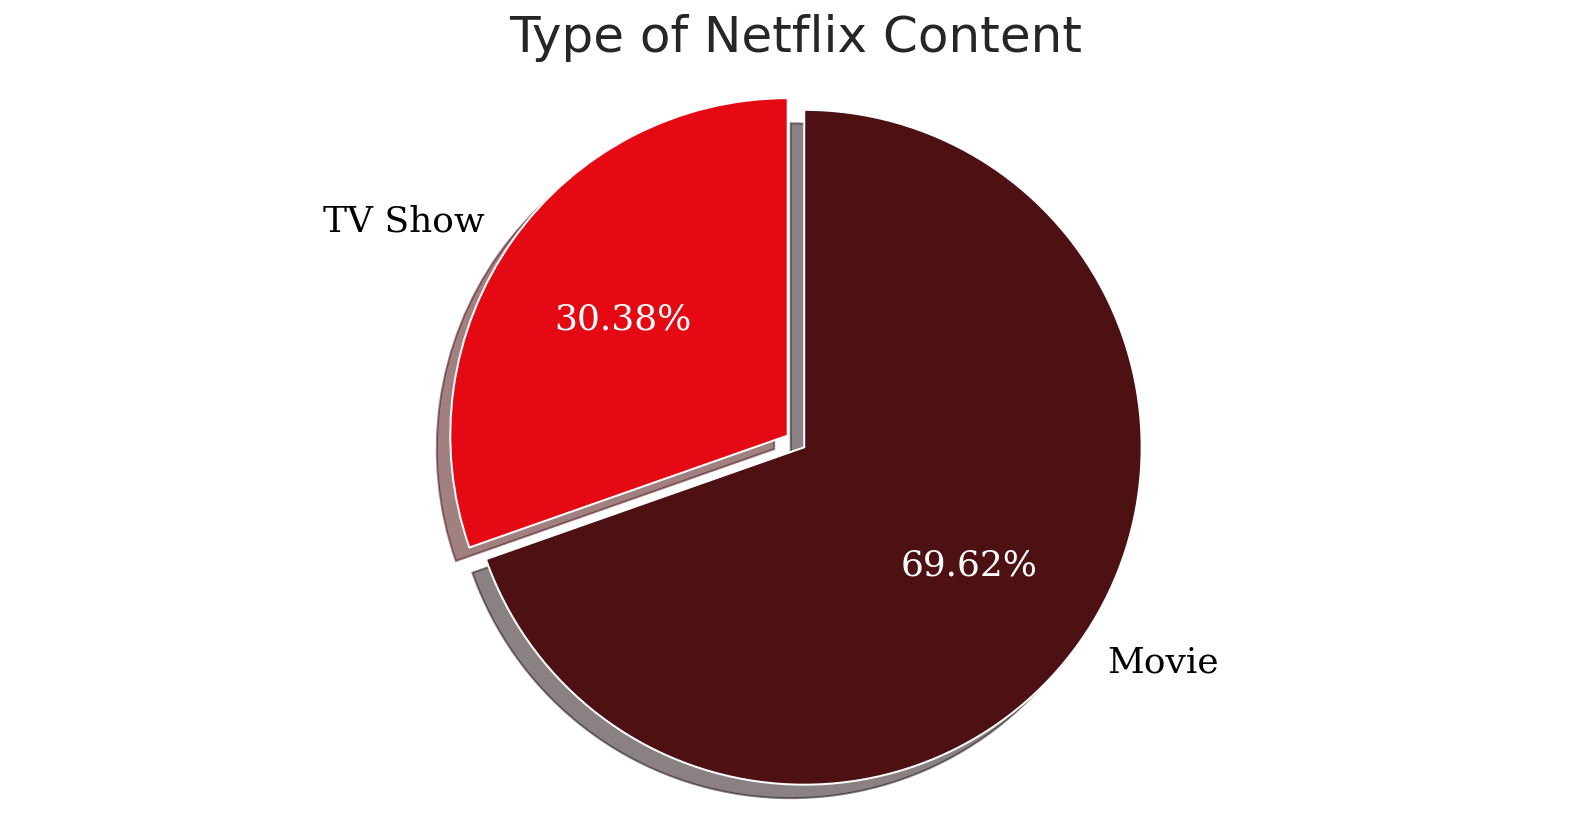

In [757]:
plt.figure(figsize=(14, 7))
labels=['TV Show', 'Movie']
patches, texts, autotexts = plt.pie(
    data['type'].value_counts().sort_values(),labels=labels,explode=[0.03,0.03],
    autopct='%1.2f%%',shadow=True, 
    colors=("#e50914" ,"#4d1114"), startangle=90)

## label만 변경해주기 
for t in texts:
    t.set_color("black")
    t.set_fontproperties('serif')
    t.set_fontsize(18)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontproperties('serif')
    t.set_fontsize(18)

plt.title('Type of Netflix Content', fontsize=25)
plt.axis('equal')
plt.show()

### (2) Number of contents added by year(연도별 추가된 컨텐츠개수)


In [758]:
df_tv = data[data["type"] == "TV Show"]
df_movies = data[data["type"] == "Movie"]

df_movies

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,IMDB,year,month,day,first_country
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",7.4,2021,9,25,United States
6,6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,2021-09-24,2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,NaN,2021,9,24,NaN
7,7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",NaN,2021,9,24,United States
9,9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,2021-09-24,2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...,NaN,2021,9,24,United States
12,12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",2021-09-23,2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...,NaN,2021,9,23,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871,8871,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan",2016-03-09,2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,NaN,2016,3,9,United Arab Emirates
8872,8872,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",NaN,2019,11,20,United States
8874,8874,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,7.7,2019,11,1,United States
8875,8875,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",NaN,2020,1,11,United States


넷플릭스의 영화 수 증가율은 TV 프로그램의 증가율보다 훨씬 높습니다.
2018년과 2019년에 약 1200편의 새로운 영화가 추가되었습니다.
2013년부터 시작된 콘텐츠 성장

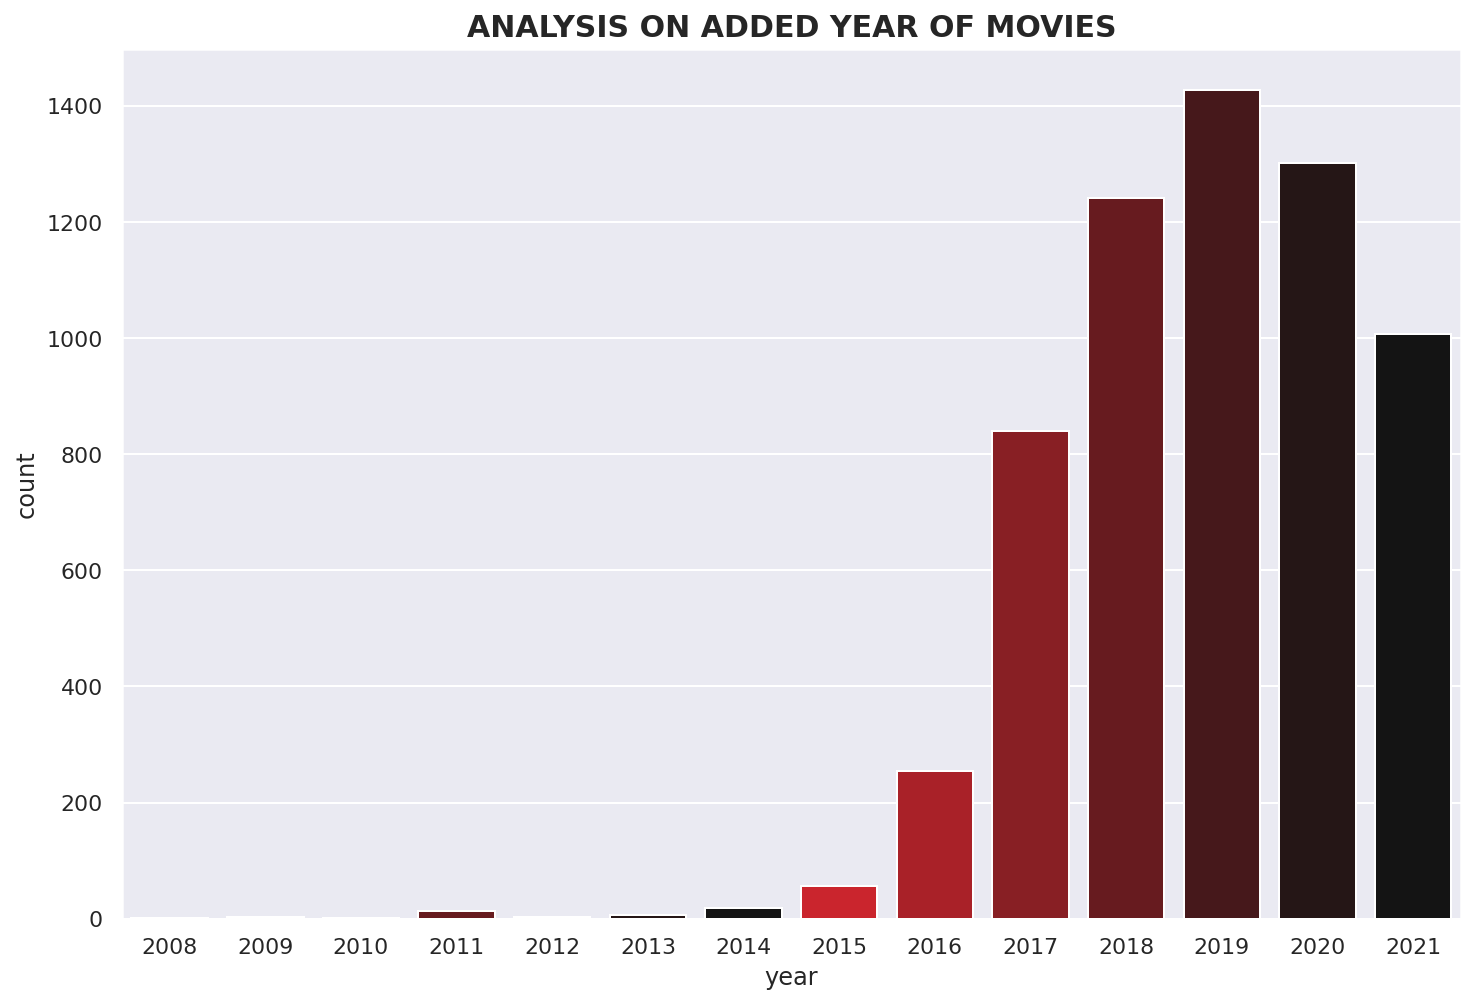

In [759]:
plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax = sns.countplot(x="year", data=df_movies, palette= grad) #order=df_movies['year'].value_counts().index[1:15])

plt.title('ANALYSIS ON ADDED YEAR OF MOVIES', fontsize=15, fontweight='bold')
plt.show()

In [760]:
import plotly.graph_objects as go
df_content = data['year'].value_counts().reset_index().rename(columns = {
    'year' : 'count', 'index' : 'year'}).sort_values('year')
df_content['percent'] = df_content['count'].apply(lambda x : 100*x/sum(df_content['count']))


df_tv1 = df_tv['year'].value_counts().reset_index().rename(columns = {
    'year' : 'count', 'index' : 'year'}).sort_values('year')
df_tv1['percent'] = df_tv1['count'].apply(lambda x : 100*x/sum(df_tv1['count']))


df_movies = df_movies['year'].value_counts().reset_index().rename(columns = {
    'year' : 'count', 'index' : 'year'}).sort_values('year')
df_movies['percent'] = df_movies['count'].apply(lambda x : 100*x/sum(df_movies['count']))

t1 = go.Scatter(x=df_movies['year'], y=df_movies["count"], name="Movies", marker=dict(color="#4d1114"))
t2 = go.Scatter(x=df_tv1['year'], y=df_tv1["count"], name="TV Shows", marker=dict(color="#e50914"))
t3 = go.Scatter(x=df_content['year'], y=df_content["count"], name="Total Contents", marker=dict(color="#142FE0"))

data = [t1, t2, t3]

layout = go.Layout(title="Content added over the years", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

# 연도별 추가된 작품 수

### 1) 연도별 추가된 작품 수 그래프 동향
- 그래프에서 2015년도 부터 추가된 작품의 수가 많아지는 조짐을 보이고있습니다.
- TV Show에 비해 Movie의 수요가 더 많은 것을 알 수 있습니다. 
- TV Show의 경우 2017년 400개, 2019년 600개의 작품이 추가되었습니다.
- Moviesms 2017년 800개가 넘는 작품이 추가된 후 2019년 1400개가 추가되었지만 그 이후 하락세를 보입니다.

### 2)연도별 매출 및 손익 트렌드 차트와의 비교 분석

- 2010년이후 넷플릭스는 본격적인 글로벌 공략을 시작하면서 매출이 크게 증가했습니다.
- 그러나 미국이나 글로벌이나 구독자를 유인할 콘텐츠가 없다면힘들다는 판단에 성장의 한계를 느끼고 2012년부터 오리지널 콘텐츠 투자를 강화하고 2013년 ‘하우스 오브 카드’발표를 시작으로 본격적으로 오리널 콘텐츠 투자를 추진합니다.
- 이러한 오리지널 콘텐츠 전략과 적극적인 글로벌 공략 전략이 맞아들면서 넷플릭스 매출 성장은 점점 가속도가 붙기 시작합니다.
- 2016년 ! 2018년 연속해서 연간 30%가 넘는 고성장을 지속하죠.
- 오리지널 콘텐츠에 대한 투자가 어느 정도 가시화되는 2017년부터 넷플릭스 손익이 나면서 손익율도 높아졌습니다. 2019년에는 사상 최고로 높은 9.3% 손익율을 기록했습니다.
- 2019년은 동영상 스트리밍 서비스를 시작하는 경쟁사들이 대거 등장하고, 견제가 심해지면서 넷플릿스 성장세가 약간 꺽인 모습을 보여줍니다.

### 3) 넷플릭스 오리지널 컨텐츠 투자

- 2020년도에는 2019년도 보다 컨텐츠에 대한 투자가 낮아진 모습을 보여줍니다.
- 반면 투자는 적었지만 코로나의 여파로 많은 사람들이 자택에서 오랜시간 지냈었습니다. 그래서 넷플릭스의 구독자 수가 증가한 것을 알 수 있습니다.


# 장르수  TOP20

In [761]:
#tv_genere = genere('TV Show')
#movie_genere = genere('movie')

In [825]:
tv_count =tv_genere.sort_values(by = 'count' ,ascending=False).reset_index()
tv_count = tv_count.head(15)


In [826]:
tv_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   15 non-null     int64 
 1   genere  15 non-null     object
 2   count   15 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 488.0+ bytes


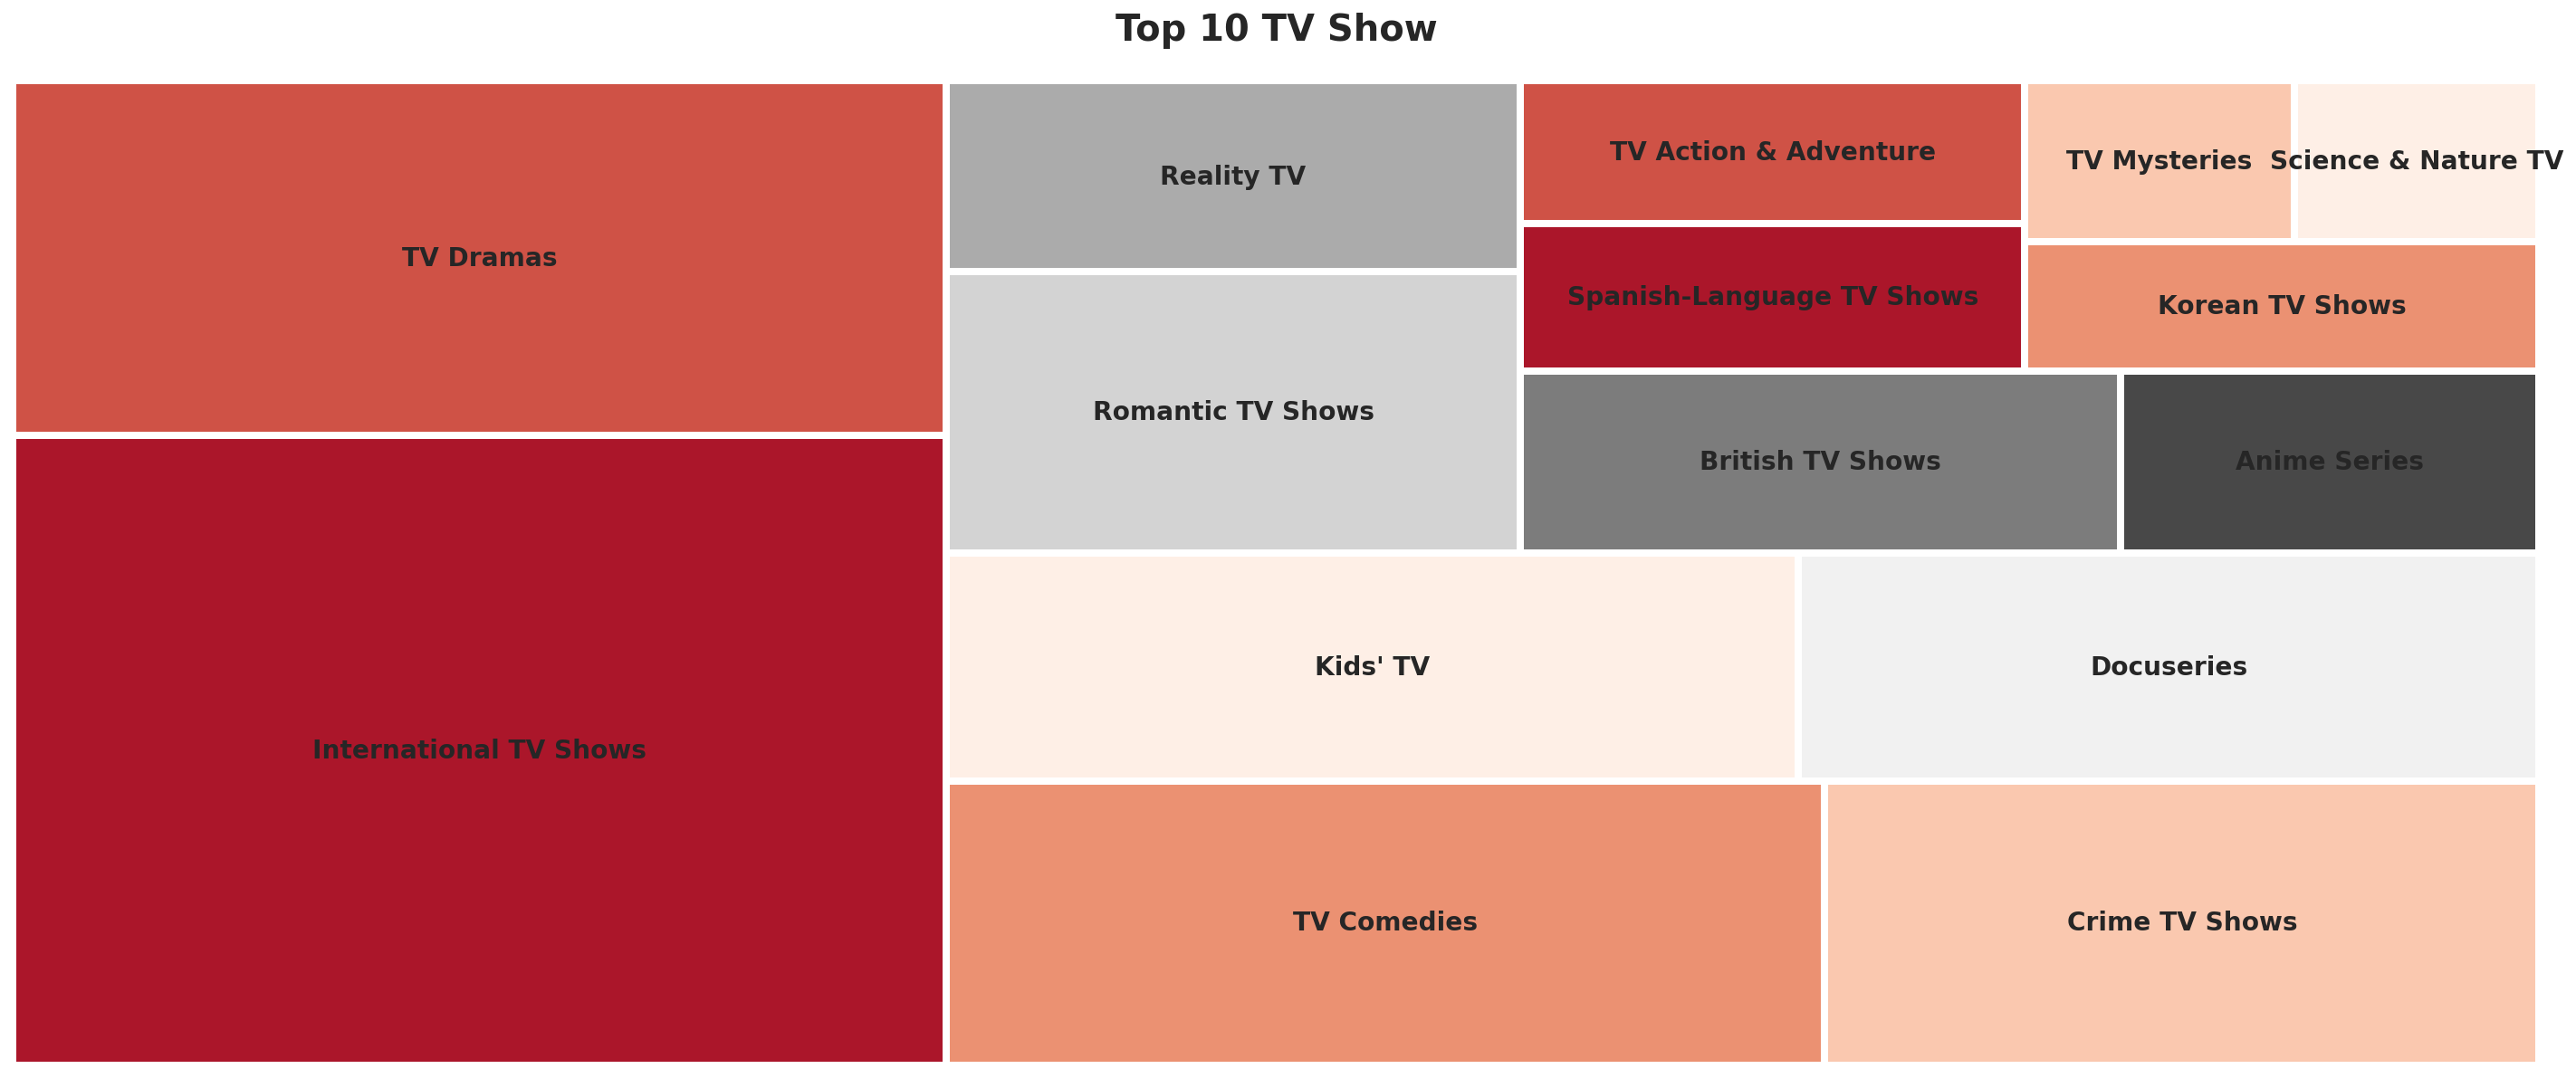

In [828]:
import matplotlib.pyplot as plt
import squarify

y = tv_count
#y.value = int(y.count)
#y.genere = str(top10_tv.genere)
fig = plt.figure(figsize=(25, 10))
squarify.plot(sizes = y['count'], label = y['genere'], color=sns.color_palette("RdGy", n_colors=10),
             linewidth=4, text_kwargs={'fontsize':14, 'fontweight' : 'bold'})
plt.title('Top 10 TV Show', position=(0.5, 1.0+0.03), fontsize = 20, fontweight='bold')
plt.axis('off')
plt.show()